In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import json

2023-05-01 01:37:08.102756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 01:37:11.495206: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-01 01:37:11.495348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/

In [2]:
print(tf.__version__)

2.11.0


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 데이터 로드

In [4]:
from google.cloud import storage
bucket_name = 'practice-tensorflow'

def load_data(image_path, cate_path, img_root):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)

    # Read image_paths from GCS
    blob = bucket.blob(image_path)
    content = blob.download_as_text()
    image_paths = [os.path.join(img_root, line.strip()) for line in content.split('\n') if line]

    # Read labels from GCS
    blob = bucket.blob(cate_path)
    labels_content = blob.download_as_text()
    labels = [int(line.strip()) for line in labels_content.split('\n') if line]

    return image_paths, labels

In [5]:
def load_categories(list_category_cloth_path):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)

    # Read image_paths from GCS
    blob = bucket.blob(list_category_cloth_path)
    content = blob.download_as_text()

    categories = {i: line.split()[0] for i, line in enumerate(content.split('\n')[2:-1], 1)}
    return categories

In [6]:
def preprocess_and_load_data(image_paths, labels, img_height=224, img_width=224, batch_size=32):
    # 이미지 파일을 로드하고 전처리하는 함수

    def load_and_preprocess_image(image_path, label):
        def load_image(image_path):
            client = storage.Client()
            bucket = client.get_bucket(bucket_name)
            blob = bucket.blob(image_path.numpy().decode('utf-8'))
            image_data = blob.download_as_bytes()

            image = tf.image.decode_jpeg(image_data, channels=3)
            image = tf.image.resize(image, [img_height, img_width])
            image = image / 255.0
            return image

        image = tf.py_function(load_image, [image_path], tf.float32)
        image.set_shape((img_height, img_width, 3))

        return image, label

    # 데이터셋 생성
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [7]:
# 위의 함수들을 사용하여 데이터를 로드하고 전처리할 수 있습니다.

img_root = '1.build-model/data'

train_img_path = '1.build-model/data/train.txt'
train_cate_path = '1.build-model/data/train_cate.txt'
val_img_path = '1.build-model/data/val.txt'
val_cate_path = '1.build-model/data/val_cate.txt'
test_img_path = '1.build-model/data/test.txt'
test_cate_path = '1.build-model/data/test_cate.txt'

image_paths_train, labels_train = load_data(train_img_path, train_cate_path, img_root)
dataset_train = preprocess_and_load_data(image_paths_train, labels_train)
image_paths_val, labels_val = load_data(val_img_path, val_cate_path, img_root)
dataset_val = preprocess_and_load_data(image_paths_val, labels_val)
image_paths_test, labels_test = load_data(test_img_path, test_cate_path, img_root)
dataset_test = preprocess_and_load_data(image_paths_test, labels_test)

list_category_cloth_path = '1.build-model/data/list_category_cloth.txt'
categories = load_categories(list_category_cloth_path)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-01 01:37:15.254093: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-05-01 01:37:15.254145: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-01 01:37:15.254169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tensorflow-2-11-20230429-001337): /proc/driver/nvidia/version does not exist
2023-05-01 01:37:15.254551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebu

In [8]:
num_batches_to_take = 1000

# Train 데이터셋에서 일부만 사용
limited_dataset_train = dataset_train.take(num_batches_to_take)

# Validation 데이터셋에서 일부만 사용
limited_dataset_val = dataset_val.take(num_batches_to_take)

## 데이터셋이 잘 구성되었는지 시각화해서 확인

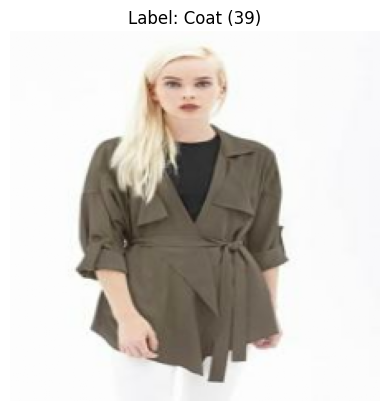

In [9]:
def get_image_and_label_at_index(dataset, target_index):
    for index, (image, label) in enumerate(dataset.unbatch()):
        if index == target_index:
            return image.numpy(), label.numpy()

# 원하는 인덱스 지정
target_index = 101

# 이미지와 레이블 가져오기
image, label = get_image_and_label_at_index(limited_dataset_train, target_index)

# # 이미지와 레이블을 시각화합니다.
plt.imshow(image)
plt.title(f"Label: {categories[label]} ({label})")
plt.axis('off')
plt.show()

# 모델 만들기 - 1차

In [10]:
num_classes = len(categories)
img_height = 224
img_width = 224

model = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [11]:
# epochs = 3

# history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

In [12]:
# test_loss, test_acc = model.evaluate(dataset_test, verbose=2)
# print(f'\nTest accuracy: {test_acc}')

In [13]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

# 모델 만들기 - 2차

## 성능을 높이도록 데이터세트 구성하기

In [14]:
dataset_train = dataset_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_val = dataset_val.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## 데이터 증강

In [15]:
from tensorflow import keras

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

## dropout

In [20]:
model = Sequential([
    # data_augmentation,
    # layers.Rescaling(1./255),
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 128)     

In [21]:
epochs = 5

history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

Epoch 1/5
438/438 [==============================] - 641s 1s/step - loss: 2.4882 - accuracy: 0.3378 - val_loss: 2.1747 - val_accuracy: 0.4030
Epoch 2/5
438/438 [==============================] - 638s 1s/step - loss: 1.9818 - accuracy: 0.4354 - val_loss: 2.0537 - val_accuracy: 0.4170
Epoch 3/5
438/438 [==============================] - 644s 1s/step - loss: 1.6061 - accuracy: 0.5289 - val_loss: 2.1511 - val_accuracy: 0.4015
Epoch 4/5
438/438 [==============================] - 638s 1s/step - loss: 1.1079 - accuracy: 0.6628 - val_loss: 2.5485 - val_accuracy: 0.3940
Epoch 5/5
438/438 [==============================] - 640s 1s/step - loss: 0.6239 - accuracy: 0.8074 - val_loss: 3.2337 - val_accuracy: 0.4010


In [24]:
test_loss, test_acc = model.evaluate(dataset_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

125/125 - 860s - loss: 4.3311 - accuracy: 0.0217 - 860s/epoch - 7s/step

Test accuracy: 0.02174999937415123


## 훈련 결과 시각화하기

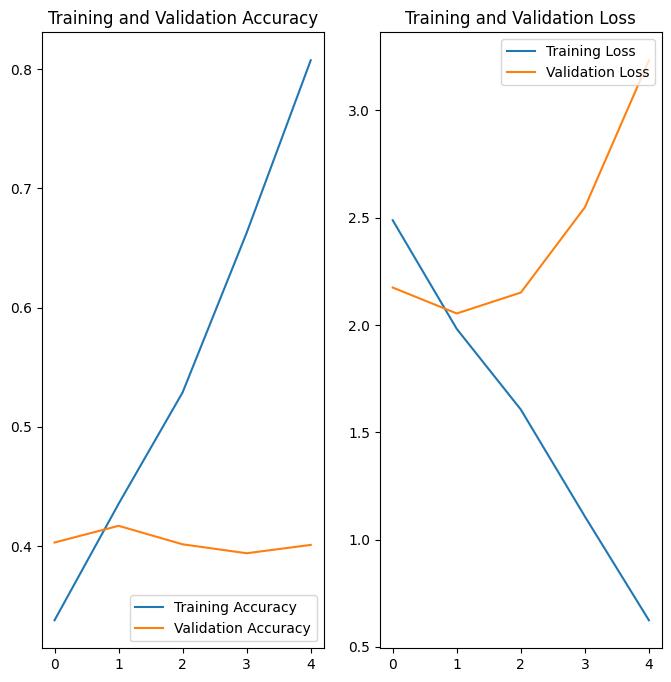

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 모델 만들기 - 3차

## 사전 훈련된 모델 사용하기 - MobileNetV2

+ dropout 적용

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# 사전 훈련된 가중치를 동결합니다.
base_model.trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_8 (Dense)             (None, 50)                64050     
                                                                 
Total params: 2,322,034
Trainable params: 64,050
Non-trainable params: 2,257,984
_________________________________________________________________


In [28]:
epochs = 10

history = model.fit(dataset_train, validation_data=dataset_val, epochs=epochs)

Epoch 1/10
438/438 [==============================] - 231s 527ms/step - loss: 1.4842 - accuracy: 0.5550 - val_loss: 1.5308 - val_accuracy: 0.5525
Epoch 2/10
438/438 [==============================] - 229s 523ms/step - loss: 1.3550 - accuracy: 0.5930 - val_loss: 1.5552 - val_accuracy: 0.5485
Epoch 3/10
438/438 [==============================] - 231s 527ms/step - loss: 1.2643 - accuracy: 0.6166 - val_loss: 1.5189 - val_accuracy: 0.5710
Epoch 4/10
438/438 [==============================] - 232s 530ms/step - loss: 1.1981 - accuracy: 0.6343 - val_loss: 1.5718 - val_accuracy: 0.5490
Epoch 5/10
438/438 [==============================] - 230s 526ms/step - loss: 1.1450 - accuracy: 0.6486 - val_loss: 1.5503 - val_accuracy: 0.5555
Epoch 6/10
438/438 [==============================] - 230s 525ms/step - loss: 1.0972 - accuracy: 0.6654 - val_loss: 1.5582 - val_accuracy: 0.5550
Epoch 7/10
438/438 [==============================] - 231s 526ms/step - loss: 1.0576 - accuracy: 0.6775 - val_loss: 1.5544 -

In [29]:
test_loss, test_acc = model.evaluate(dataset_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

125/125 - 964s - loss: 1.7164 - accuracy: 0.5403 - 964s/epoch - 8s/step

Test accuracy: 0.5402500033378601


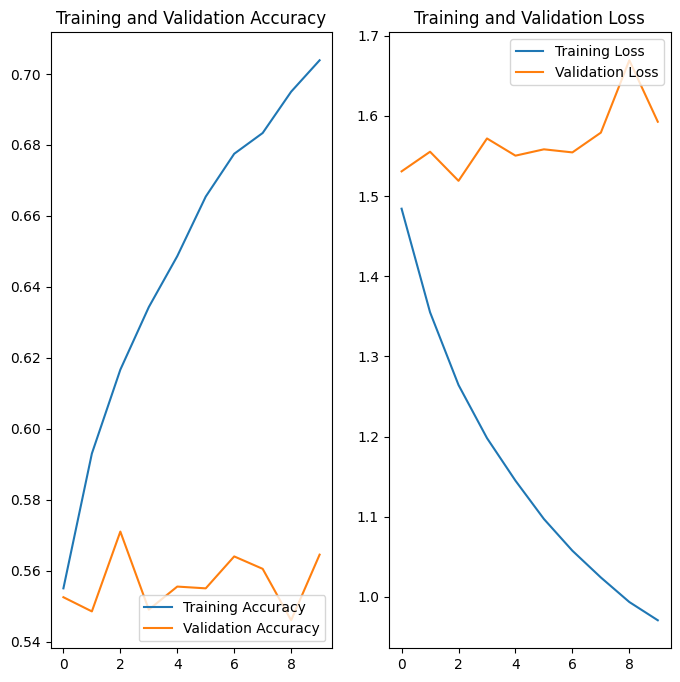

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# 모델 저장하기

In [31]:
# 모델을 로컬 디스크에 저장합니다.
model.save('../models/my_model.h5')

from google.cloud import storage

def upload_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Upload a file to GCS bucket."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    print(f"File {source_file_name} uploaded to {destination_blob_name}.")

source_file_name = '../models/my_model.h5'
destination_blob_name = '1.build-model/models/my_model.h5'

# 저장한 모델을 GCS에 업로드합니다.
upload_to_gcs(bucket_name, source_file_name, destination_blob_name)

File ../models/my_model.h5 uploaded to 1.build-model/models/my_model.h5.
